# Classification of Musical Instruments by Sound

#### Final Project for CSCI E-89 Deep Learning  Harvard University 


# Problem Statement:  

The goal is to develop the model which will allow us to recognize music instrument from the sound of it. I will use convolutional neural network, implementing it using Keras -  high-level neural networks API, running on top of TensorFlow. As dataset, I will use The NSynth Dataset, which contains sounds of solitary musical notes from various instrument families.

# Dataset Description: 

NSynth is an audio dataset containing 305,979 musical notes, each with a unique pitch, timbre, and envelope. For 1,006 instruments from commercial sample libraries, authors generated four second, monophonic 16kHz audio snippets, referred to as notes with indicating the instrument family the record came from.

•	Large size (zipped): 23.5 Gb, 305,979 record.

•	Subset that was used: 1.13 Gb, 9,460 record for training; 371 Mb, 3,039 files for testing.

https://magenta.tensorflow.org/datasets/nsynth

Each sample contains large description with a lot of information, like note, pitch, velocity and so on, but, as I intended to train my model on sound file only, I didn’t take this information into the account.

# Data reading and preprocessing:

We are interested only in wav files. Here are the links for downloading:
http://download.magenta.tensorflow.org/datasets/nsynth/nsynth-train.jsonwav.tar.gz
http://download.magenta.tensorflow.org/datasets/nsynth/nsynth-valid.jsonwav.tar.gz
http://download.magenta.tensorflow.org/datasets/nsynth/nsynth-test.jsonwav.tar.gz
Total size of 3 datasets is 23.5 Gb.

I used "nsynth-valid" folder as train set and "nsynth-test" as validation. "nsynth-train" is too huge, while I got model with high accuracy on much smallel dataset ("nsynth-valid" folder). 
Unzip test and validation folders to folder which contains your Jupitar notebook.
It's important not to mix folders, because instruments (from which records were taken) has not to overlap in train and validation set. 



In [18]:
import os

#training set is huge (23 Gb), that's why let's use "nsynth-valid" folder as train set and "nsynth-test" as validation
#It's important not to mix folders, because instruments (from which records were taken) has not to overlap with each other

train_path = "./nsynth-valid/audio/"
val_path = "./nsynth-test/audio/"

In [23]:
import shutil
import librosa
import numpy as np
from keras.utils import to_categorical
from random import shuffle

def clean_data(path):
    """
    We can split name using “_” and use first element as instrument family and second as type 
    (acoustic, electronic, synthetic). I would like to proceed only with acoustic and electronic, 
    so let’s delete synthetic. 
    Also, dataset contains records of vocal, with is not instrument, so let’s delete them too. 
    """
    for filename in os.listdir(path):
        sp = filename.split('_')
        if((sp[1]=="synthetic") or (sp[0]=="vocal") or (sp[0]=="synth")):
            os.remove(path+filename)


#we can use first part of file name as instrument family indemnificatory, 
#so there is the function to get all possible labels:    
def get_labels(path):
    """
    we can use first part of file name as instrument family indemnificatory, 
    so there is the function to get all possible labels:
    """
    labels = set([])
    for filename in os.listdir(path):
        sp = filename.split('_')
        labels.add(sp[0])
    labels = list(labels)
    return (labels)
       

def wav2mfcc(file_path, max_len=11):
    wave, sr = librosa.load(file_path, mono=True, sr=None)
    wave = wave[::3]
    mfcc = librosa.feature.mfcc(wave, sr=16000)
    mfcc = mfcc[:, :max_len]
    return mfcc       

def get_data(path, max_len):
    """"
    Function to read data from given folder and convert it to pair X, Y 
    where X is MFCC transformation of file and Y is label of 
    instrument family the sound was recorded from. 
    """"
    labels = get_labels(train_path)
    X=[]
    Y=[]
    files_list = os.listdir(path)
    shuffle(files_list)
    for filename in files_list:
        sp = filename.split('_')
        x=wav2mfcc(path+filename, max_len)
        if(sp[0] not in labels):
            print(sp[0] + "Error!") 
        y = labels.index(sp[0])
        X.append(x)
        Y.append(y)
    X=np.array(X)
    Y=np.array(Y)
    return X,Y

In [ ]:
clean_data(train_path)
clean_data(val_path)

After cleaning, we got 1.13 Gb, 9,460 records for training; 371 Mb, 3,039 files for testing.

Actual file reading and saving processed arrays to .npy files (for future reference):

In [24]:
labels = get_labels(train_path)

t = 20 #We'll trim data to this length

X_train, Y_train =get_data(train_path, t)
np.save("X_train" + '.npy', X_train)
np.save("Y_train" + '.npy', Y_train)

X_val, Y_val =get_data(val_path, t)
np.save("X_val" + '.npy', X_val)
np.save("Y_val" + '.npy', Y_val)


Reshaping to feed to Conv2D: 

In [31]:
from keras.utils import to_categorical
mfcc_output_size = 20 #constant
channel = 1
epochs = 10
batch_size = 20

X_train = np.load("X_train" + '.npy')
Y_train = np.load("Y_train" + '.npy')

X_val = np.load("X_val" + '.npy')
Y_val = np.load("Y_val" + '.npy')

X_train = X_train.reshape(X_train.shape[0], mfcc_output_size, t, channel)
Y_train = to_categorical(Y_train)

X_val = X_val.reshape(X_val.shape[0], mfcc_output_size, t, channel)
Y_val = to_categorical(Y_val)

Let’s check what we’ve get:

In [77]:
labels = get_labels(train_path)

print(labels)
print (X_train.shape)
print (X_val.shape)


['keyboard', 'flute', 'mallet', 'guitar', 'bass', 'reed', 'string', 'brass', 'organ']
(9459, 20, 20, 1)
(3039, 20, 20, 1)


So we have 9 classes of instruments; 9459 samples in training set (20x20 each) and 3039 in validation set.

# Building a model

Defining the model:

In [33]:
import keras
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D

def build_model():
    model = Sequential()
    model.add(Conv2D(52, kernel_size=(2, 2), activation='relu', input_shape=(mfcc_output_size, t, channel)))
    model.add(Conv2D(64, kernel_size=(2, 2), activation='relu'))
    model.add(Conv2D(132, kernel_size=(2, 2), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(64, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(len(labels), activation='softmax'))
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adam(),
                  metrics=['accuracy'])
    return model


In [34]:
model = build_model()
model.summary()
model.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_val, Y_val))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 19, 19, 52)        260       
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 18, 18, 64)        13376     
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 17, 17, 132)       33924     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 8, 8, 132)         0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 8, 8, 132)         0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 8448)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 100)               844900    
__________

Validation error after 10 epochs is 98.4%.  Each epoch took about 1 minute, so the whole training process was completed in 10 minutes. Much faster than reading the files. There is no need to continue training, as validation error starts to fluctuate after 7th epoch.



In [13]:
model.save('notes.h5')

In [ ]:
from keras.models import load_model
model = load_model('notes.h5')

In [55]:
def predict(filepath, model):
    """
    Function for predicting from wav file 
    """
    sample = wav2mfcc(filepath, t)
    sample_reshaped = sample.reshape(1, mfcc_output_size, t, channel)
    return labels[np.argmax(model.predict(sample_reshaped))]

In [69]:
def predict_set(path, model):
    """
    Function for prediction for all files in the folder, which returns list of targeted and predicted instrument labels:
    """
    target=[]
    predicted=[]

    for filename in os.listdir(path):
        sp = filename.split('_')
        target.append(sp[0])
        predicted.append(predict(path+filename, model))
    
    return target, predicted
        
    

Predicting labels for all files in Validation set:

In [70]:
target, predicted = predict_set(val_path, model)

print(target[0])
print(predicted[0])

bass
bass


Here are some examples of predicting files from validation set:

In [83]:
import IPython.display as ipd

filename = "organ_electronic_001-048-127.wav"
print("Targeted : " + filename.split('_')[0])
print("Predicted: " + predict(test_path+'/' + filename, model=model))
ipd.Audio(test_path+'/' + filename)

Targeted : organ
Predicted: organ


In [85]:
filename = "guitar_acoustic_010-046-025.wav"
print("Targeted : " + filename.split('_')[0])
print("Predicted: " + predict(test_path+'/' + filename, model=model))
ipd.Audio(test_path+'/' + filename)

Targeted : guitar
Predicted: guitar


In [86]:
filename = "keyboard_acoustic_004-048-075.wav"
print("Targeted : " + filename.split('_')[0])
print("Predicted: " + predict(test_path+'/' + filename, model=model))
ipd.Audio(test_path+'/' + filename)

Targeted : keyboard
Predicted: keyboard


In [87]:
filename = "mallet_acoustic_047-086-025.wav"
print("Targeted : " + filename.split('_')[0])
print("Predicted: " + predict(test_path+'/' + filename, model=model))
ipd.Audio(test_path+'/' + filename)

Targeted : mallet
Predicted: mallet


In [89]:
filename = "string_acoustic_080-048-025.wav"
print("Targeted : " + filename.split('_')[0])
print("Predicted: " + predict(test_path+'/' + filename, model=model))
ipd.Audio(test_path+'/' + filename)

Targeted : string
Predicted: string


Let’s make a confusion matrix:

In [76]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(target, predicted, labels=labels)

In [72]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

#source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[650   0   0   7   0   0   0   0   1]
 [  0  50   0   0   0   1   1   3   0]
 [  1   0 192   7   0   0   0   0   2]
 [  2   0   2 646   0   1   1   0   0]
 [  0   0   0   0 160   0   0   0   0]
 [  0   0   0   0   0 230   0   5   0]
 [  4   0   0   0   0   0 300   0   2]
 [  0   0   0   0   0   7   0 261   1]
 [  0   0   0   0   0   0   0   0 502]]


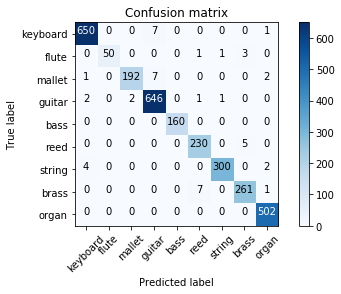

In [75]:
plot_confusion_matrix(confusion_matrix, classes=labels,
                      title='Confusion matrix')


Confusion matrix looks very good! Among miss-predicted values is keyboard predicted as guitar (7 times) and reed predicted as brass (5 times).

Let’s take a look at mel power spectrogram for several different instruments:  

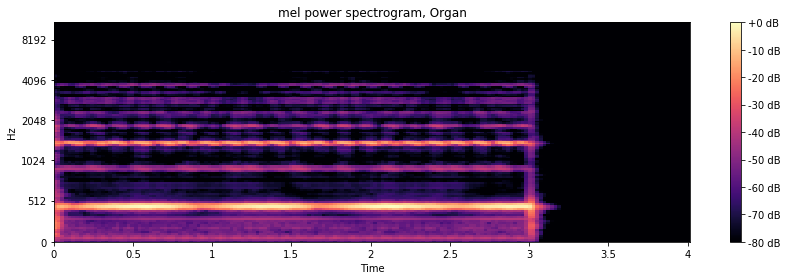

In [91]:
import matplotlib.pyplot as plt
import librosa.display
%matplotlib inline

audio_path = train_path + '/organ_electronic_104-070-127.wav'
y, sr = librosa.load(audio_path)
S = librosa.feature.melspectrogram(y, sr=sr, n_mels=128)
# Convert to log scale (dB). We'll use the peak power (max) as reference.
log_S = librosa.power_to_db(S, ref=np.max)
plt.figure(figsize=(12,4))
librosa.display.specshow(log_S, sr=sr, x_axis='time', y_axis='mel')
plt.title('mel power spectrogram, Organ')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()

ipd.Audio(audio_path)

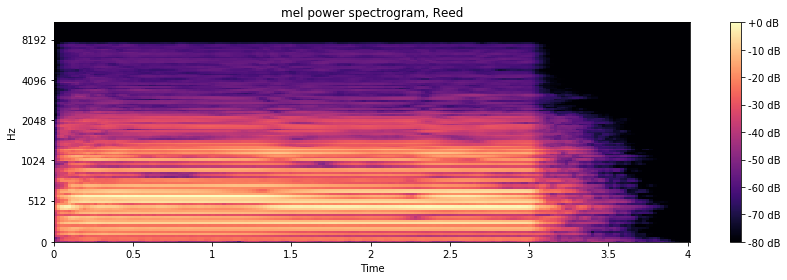

In [92]:
audio_path = train_path + '/reed_acoustic_037-036-100.wav'
y, sr = librosa.load(audio_path)
S = librosa.feature.melspectrogram(y, sr=sr, n_mels=128)
# Convert to log scale (dB). We'll use the peak power (max) as reference.
log_S = librosa.power_to_db(S, ref=np.max)
plt.figure(figsize=(12,4))
librosa.display.specshow(log_S, sr=sr, x_axis='time', y_axis='mel')
plt.title('mel power spectrogram, Reed')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()

ipd.Audio(audio_path)

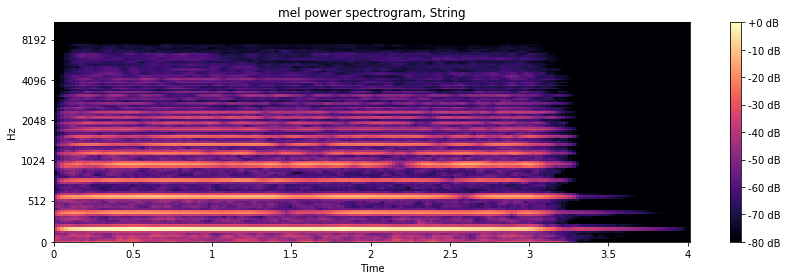

In [94]:
audio_path = train_path + '/string_acoustic_080-055-075.wav'
y, sr = librosa.load(audio_path)
S = librosa.feature.melspectrogram(y, sr=sr, n_mels=128)
# Convert to log scale (dB). We'll use the peak power (max) as reference.
log_S = librosa.power_to_db(S, ref=np.max)
plt.figure(figsize=(12,4))
librosa.display.specshow(log_S, sr=sr, x_axis='time', y_axis='mel')
plt.title('mel power spectrogram, String')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()

ipd.Audio(audio_path)

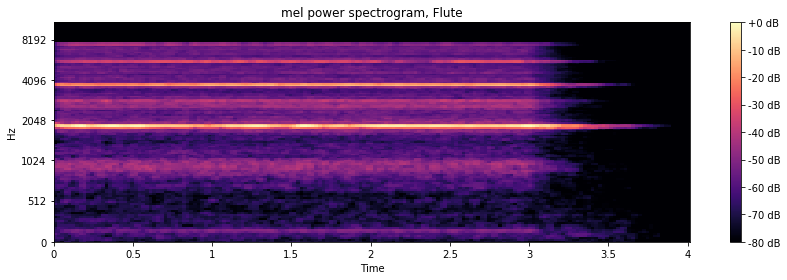

In [95]:
audio_path = train_path + '/flute_acoustic_002-094-100.wav'
y, sr = librosa.load(audio_path)
S = librosa.feature.melspectrogram(y, sr=sr, n_mels=128)
# Convert to log scale (dB). We'll use the peak power (max) as reference.
log_S = librosa.power_to_db(S, ref=np.max)
plt.figure(figsize=(12,4))
librosa.display.specshow(log_S, sr=sr, x_axis='time', y_axis='mel')
plt.title('mel power spectrogram, Flute')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()

ipd.Audio(audio_path)

# Conclusions 

I used Convolutional Neural Network to create a model for classification music instruments by sound. As datasource, I choose very clean dataset NSynth from Magenta. It contains the record of a solitary note per file. The model, implemented thought Keras, trains very fast (~10 epochs, each takes around 1 minute, was enough) and produces very good results (98% test accuracy). 

Keras provides very user-friendly user interface and consistent & simple APIs for NN development. It’s really pleasure to work with it.  

I would like to expand the model to learn how to recognize instrument not from the single note, but from actual piece of music with a single predominant instrument. I found suitable dataset – IRMAS (https://www.upf.edu/web/mtg/irmas). But model, similar to the one I successfully used for NSynth Dataset, when trained on IRMAS dataset (with modification to accommodate more complex data), gives me only 47.5% testing accuracy (number of classes – 9). Although training accuracy was ~97%, no matter how I tried to apply regularization of such model. 

Also, it would be interesting to use other sound features, which can be extracted from sound file using Librosa library, like spectral centroid, roll-off frequency, tonal centroid features, zero-crossing rate, etc. It didn’t make sense to with NSynth (as we already have ~98% test accuracy) but it might help with more complex IRMAS dataset.  I feel like to include these features, we shouldn’t just put them as additional dimension to convolutional network. I tried to build network which takes several inputs – to feed first input (mfcc) to convolutional part of the network, then flatten it and feed to second input (vector of other abovementioned feature) to dense layer, but my network failed to converge. I’m looking forward to investigate matter further.

As I discovered, problem of recognizing musical instrument from the sound of it can be successfully and easily solved if we deal with the record of the single note, but requires more sophisticated approaches if we want to classify instruments from an actual piece of music.  


# References: 

Code and technical info:

https://keras.io/

https://anaconda.org/anaconda/anaconda-navigator

https://www.python.org/

http://jupyter.org/

https://github.com/librosa/librosa

https://blog.manash.me/building-a-dead-simple-word-recognition-engine-using-convnet-in-keras-25e72c19c12b

http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py

http://nbviewer.jupyter.org/github/librosa/librosa/blob/master/examples/LibROSA%20demo.ipynb

Data source:

https://magenta.tensorflow.org/datasets/nsynth

